# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [4]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [8]:
df.columns = ["Production"]

In [9]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


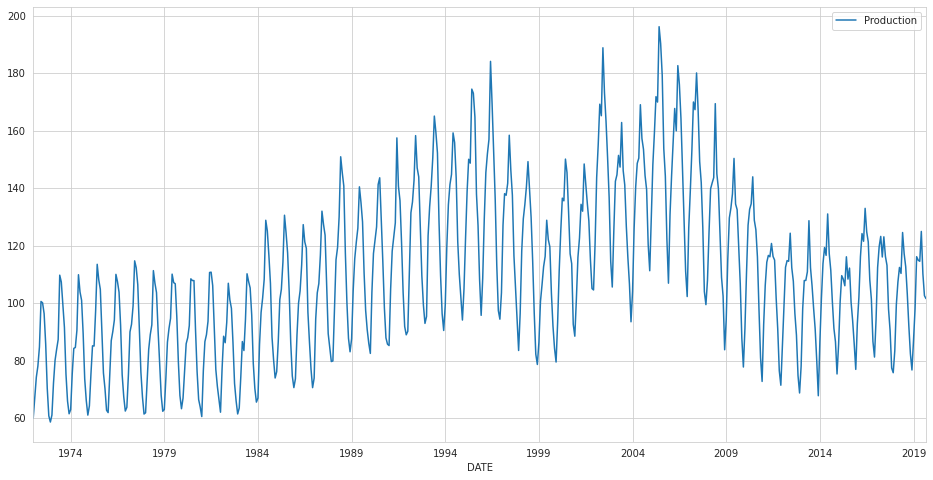

In [10]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [11]:
test_size = 24

In [12]:
test_ind = len(df)- test_size

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [19]:
X, y = generator[0]

In [20]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
n_features = train_scaled.shape[1]

### Creating Model

### with "tanh" activation function

In [23]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [26]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 15s 17ms/step - loss: 0.0269 - val_loss: 0.0050
Epoch 2/20
537/537 [==============================] - 8s 15ms/step - loss: 0.0139 - val_loss: 0.0027
Epoch 3/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 4/20
537/537 [==============================] - 8s 15ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 5/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 6/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 9/20
537/537 [==============================] - 8s 15ms/step - loss: 0.0045 - val_loss: 0.0055


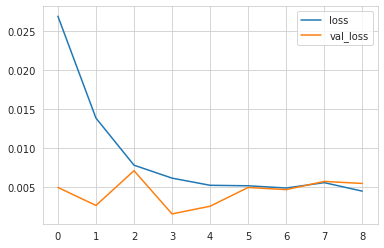

In [27]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [29]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [30]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

#### Inverse Transformations and Comparing

In [31]:
predictions = scaler.inverse_transform(predictions_scaled)

In [32]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,95.543
2017-11-01,77.438,89.196
2017-12-01,75.812,92.719
2018-01-01,83.434,103.578
2018-02-01,99.490,113.160
2018-03-01,107.315,117.702
2018-04-01,112.431,120.283
2018-05-01,110.354,120.826
2018-06-01,124.584,122.340


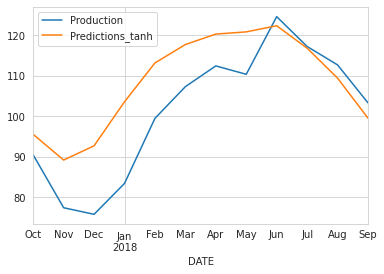

In [33]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [34]:
eval_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.5223264579609903 
mae: 8.829966958618785 
mse: 112.6453024242138 
rmse: 10.613449129487256


### with "relu" activation function

In [35]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [37]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [38]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 13s 16ms/step - loss: 0.0291 - val_loss: 0.0073
Epoch 2/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0132 - val_loss: 0.0014
Epoch 3/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0086 - val_loss: 0.0023
Epoch 4/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 5/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 6/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0071 - val_loss: 0.0026
Epoch 7/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 8/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 9/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 10/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0065 - val_l

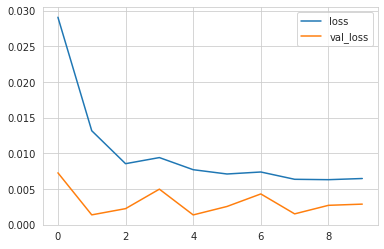

In [39]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [40]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

#### Inverse Transformations and Comparing

In [ ]:
predictions = scaler.inverse_transform(predictions_scaled)

In [41]:
compare['Predictions_relu'] = predictions
compare

,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,95.543,95.543
2017-11-01,77.438,89.196,89.196
2017-12-01,75.812,92.719,92.719
2018-01-01,83.434,103.578,103.578
2018-02-01,99.490,113.160,113.160
2018-03-01,107.315,117.702,117.702
2018-04-01,112.431,120.283,120.283
2018-05-01,110.354,120.826,120.826
2018-06-01,124.584,122.340,122.340


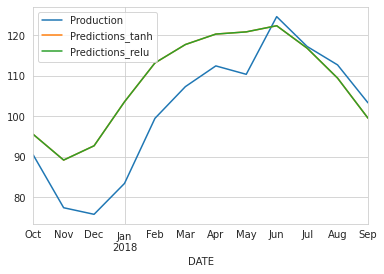

In [42]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [43]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.5223264579609903 
mae: 8.829966958618785 
mse: 112.6453024242138 
rmse: 10.613449129487256


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [44]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [45]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [46]:
model = Sequential()

model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
561/561 [==============================] - 14s 18ms/step - loss: 0.0309
Epoch 2/10
561/561 [==============================] - 10s 17ms/step - loss: 0.0105
Epoch 3/10
561/561 [==============================] - 10s 18ms/step - loss: 0.0078
Epoch 4/10
561/561 [==============================] - 12s 21ms/step - loss: 0.0077
Epoch 5/10
561/561 [==============================] - 8s 13ms/step - loss: 0.0067
Epoch 6/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0064
Epoch 7/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0065
Epoch 8/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0063
Epoch 9/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0064
Epoch 10/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0065


In [47]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [48]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 91.71760284],
       [ 83.11118732],
       [ 81.40867249],
       [ 89.51478589],
       [103.06293138],
       [113.66868449],
       [113.91543913],
       [117.96362508],
       [121.35039712],
       [112.10037246],
       [105.37680225],
       [103.52307285]])

In [49]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [50]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [51]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,91.718
2019-11-01,83.111
2019-12-01,81.409
2020-01-01,89.515
2020-02-01,103.063
2020-03-01,113.669
2020-04-01,113.915
2020-05-01,117.964
2020-06-01,121.350
2020-07-01,112.100


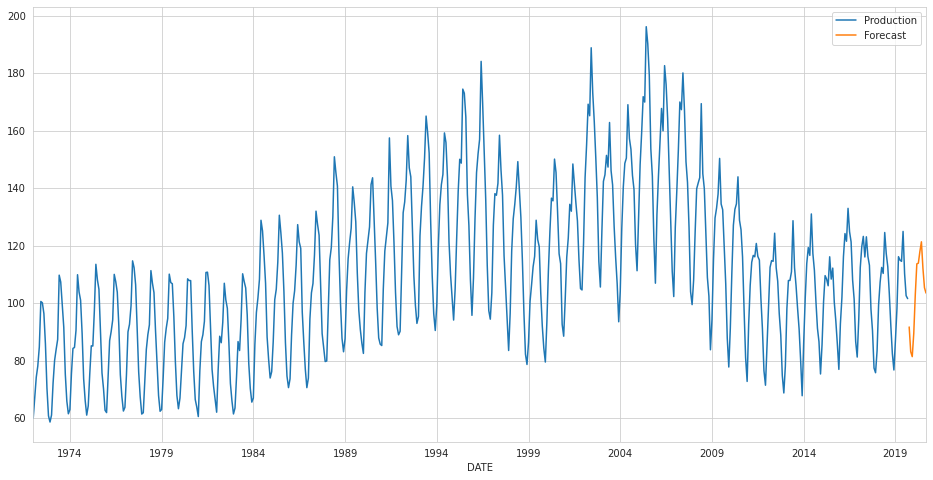

In [52]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

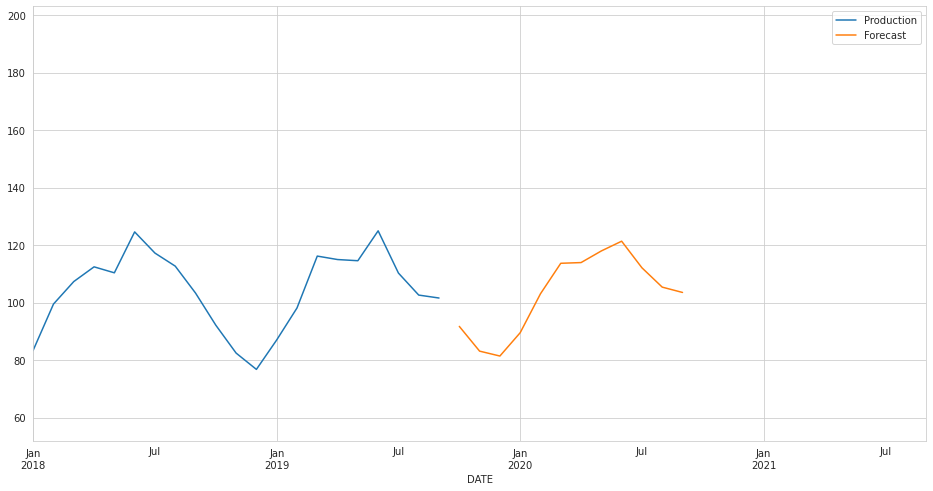

In [53]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')